[Session #6 Homework](https://colab.research.google.com/github/Jaguar838/ml-zoomcamp/blob/master/HW/06-trees/hw-06.ipynb)

In [37]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [38]:
df = pd.read_csv("https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv   ")
df.columns

Index(['JAMB_Score', 'Study_Hours_Per_Week', 'Attendance_Rate',
       'Teacher_Quality', 'Distance_To_School', 'School_Type',
       'School_Location', 'Extra_Tutorials', 'Access_To_Learning_Materials',
       'Parent_Involvement', 'IT_Knowledge', 'Student_ID', 'Age', 'Gender',
       'Socioeconomic_Status', 'Parent_Education_Level',
       'Assignments_Completed'],
      dtype='object')

In [39]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

##Preparation:

* Remove the `student_id` column.
* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution.
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [40]:
del df['student_id']

In [41]:
df.isna().sum()

,0
jamb_score,0
study_hours_per_week,0
attendance_rate,0
teacher_quality,0
distance_to_school,0
school_type,0
school_location,0
extra_tutorials,0
access_to_learning_materials,0
parent_involvement,0


In [42]:
df = df.fillna(0)

In [43]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
(len(df_train),len(df_val),len(df_test))

(3000, 1000, 1000)

In [44]:


df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [45]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the `jamb_score` variable.

* Train a model with `max_depth=1`

In [46]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [47]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [48]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



Which feature is used for splitting the data?

* **`study_hours_per_week`**
* `attendance_rate`
* `teacher_quality`
* `distance_to_school`


## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [50]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [51]:
y_pred = rf.predict(X_val)

root_mean_squared_error(y_val, y_pred)

42.13724207871227

What's the RMSE of this model on validation?

* 22.13
* **42.13**
* 62.13
* 82.12

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [53]:
from tqdm.auto import tqdm

In [82]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = np.sqrt(root_mean_squared_error(y_val, y_pred))

    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

In [81]:
df_scores.round(3)
df_scores.sort_values(by = "rmse", ascending = True).head(3)

,max_depth,n_estimators,rmse
8,10,90,6.338288
7,10,80,6.341160
9,10,100,6.344327


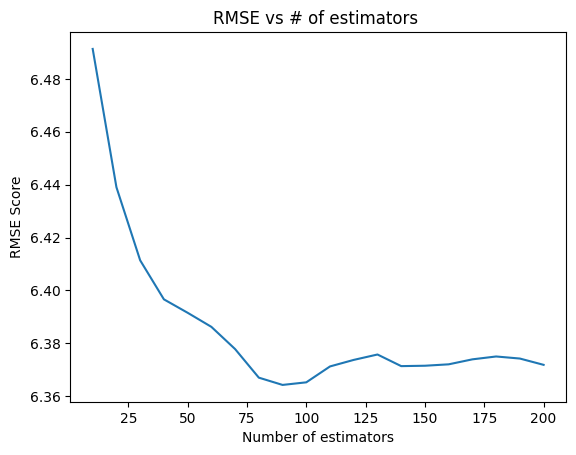

In [83]:
# Plot scores by estimators
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.xlabel("Number of estimators")
plt.ylabel("RMSE Score")
plt.title("RMSE vs # of estimators ")
plt.show()

After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- **80** (approximately)
- 200

We can use `warm_start=True` to train faster. In this case, we train only additional 10 new trees each time, not the entire ensemble from scratch like previously

```
warm_start : bool, default=False
    When set to ``True``, reuse the solution of the previous call to fit
    and add more estimators to the ensemble, otherwise, just fit a whole
    new forest. See :term:`the Glossary <warm_start>`.
```

In [57]:
scores = []

rf = RandomForestRegressor(
    n_estimators=1,
    random_state=1,
    n_jobs=-1,
    warm_start=True,
)

for n in tqdm(range(10, 201, 10)):
    rf.n_estimators = n
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = np.sqrt(root_mean_squared_error(y_val, y_pred))

    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

It's 41 seconds instead of 5 minutes now

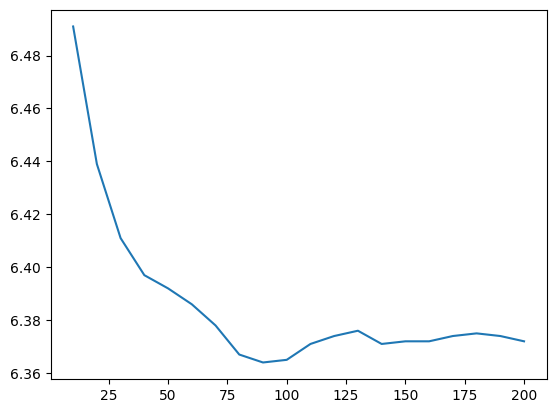

In [58]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE
* Fix the random seed: `random_state=1`

In [59]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(
        n_estimators=0,
        max_depth=d,
        random_state=1,
        n_jobs=-1,
        warm_start=True
    )

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(root_mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

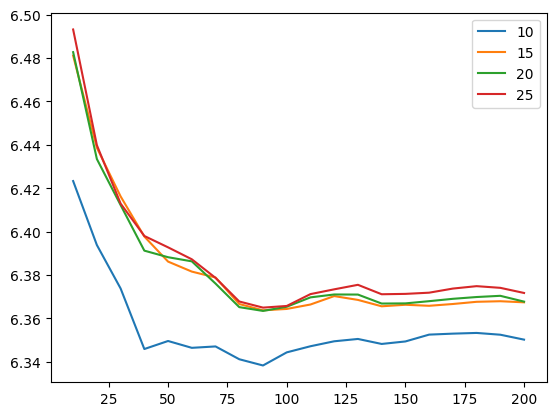

In [60]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

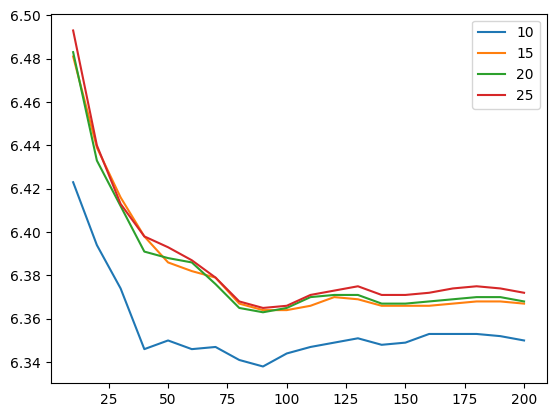

In [61]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse.round(3), label=d)

plt.legend()
plt.show()

What's the best `max_depth`, using the mean RMSE?

* **10**
* 15
* 20
* 25

Many of you had 10 as the answer, and it's pretty close, so we count **10** as the correct answer too

# Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split.
When doing it, we can calculate "gain" - the reduction in impurity before and after the split.
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field.

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [62]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [63]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311


What's the most important feature (among these 4)?

* **`study_hours_per_week`**
* `attendance_rate`
* `distance_to_school`
* `teacher_quality`


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [64]:
import xgboost as xgb

In [65]:
features = dv.feature_names_
features

['access_to_learning_materials=No',
 'access_to_learning_materials=Yes',
 'age',
 'assignments_completed',
 'attendance_rate',
 'distance_to_school',
 'extra_tutorials=No',
 'extra_tutorials=Yes',
 'gender=Female',
 'gender=Male',
 'it_knowledge=High',
 'it_knowledge=Low',
 'it_knowledge=Medium',
 'parent_education_level',
 'parent_education_level=Primary',
 'parent_education_level=Secondary',
 'parent_education_level=Tertiary',
 'parent_involvement=High',
 'parent_involvement=Low',
 'parent_involvement=Medium',
 'school_location=Rural',
 'school_location=Urban',
 'school_type=Private',
 'school_type=Public',
 'socioeconomic_status=High',
 'socioeconomic_status=Low',
 'socioeconomic_status=Medium',
 'study_hours_per_week',
 'teacher_quality']

In [66]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [67]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [68]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [69]:
%%capture output_03

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [70]:
scores['eta=0.3'] = parse_xgb_output(output_03)

In [71]:
%%capture output_01

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [72]:
scores['eta=0.1'] = parse_xgb_output(output_01)

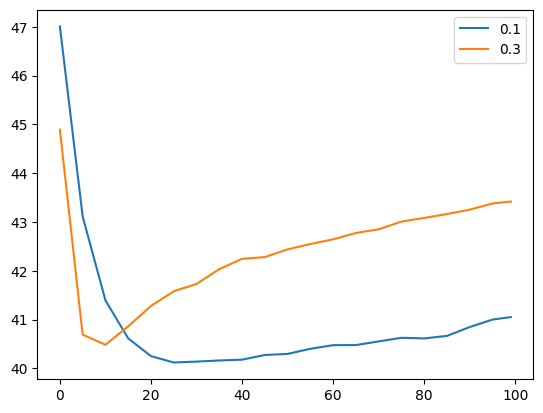

In [73]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* **0.1**
* Both give equal value

Note that rounding doesn't change the answer:

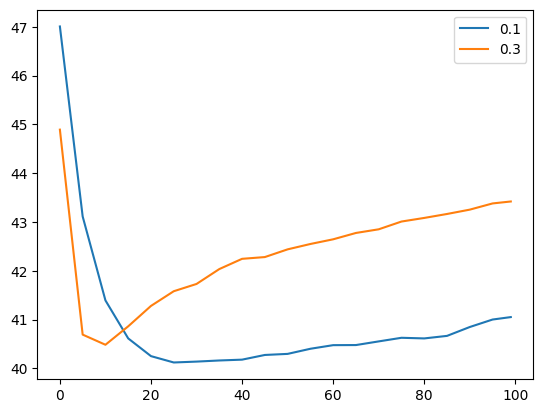

In [74]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc.round(3),
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc.round(3),
        label='0.3')
plt.legend()
plt.show()